## Imports

In [1]:
import json
import pandas as pd
import copy
import matplotlib as plt
import seaborn as sns

## Change annotations to 7 categories (TACO dataset)

In [2]:
# Load JSON

with open('../data/TACO/annotations.json') as f:
    data_taco = json.load(f)

In [3]:
# Pull dictionary of categories (60)

dict_taco = {}

for x in range(60):
    id = data_taco['categories'][x]['id']
    name = data_taco['categories'][x]['name']
    dict_taco[id] = name

In [4]:
# Instantiate new dictionary of 5 categories

final_categories = {
    0: 'Paper',
    1: 'Plastic',
    2: 'Glass',
    3: 'Metal',
    4: 'Organic',
    5: 'E-Waste',
    6: 'Non-recyclable'
}

In [5]:
# Create new mapping between categories

unique_cat_taco = list(dict_taco.values())
unique_cat_ids = set(key for key, val in dict_taco.items())

matching_cat_final = [
'Non-recyclable',
'E-Waste',
'Non-recyclable',
'Non-recyclable',
'Plastic',
'Plastic',
'Glass',
'Plastic',
'Metal',
'Glass',
'Non-recyclable',
'Metal',
'Metal',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Paper',
'Plastic',
'Non-recyclable',
'Non-recyclable',
'Plastic',
'Organic',
'Glass',
'Plastic',
'Metal',
'Plastic',
'Paper',
'Non-recyclable',
'Paper',
'Paper',
'Paper',
'Non-recyclable',
'Plastic',
'Plastic',
'Non-recyclable',
'Plastic',
'Plastic',
'Non-recyclable',
'Plastic',
'Plastic',
'Plastic',
'Plastic',
'Non-recyclable',
'Plastic',
'Plastic',
'Plastic',
'Metal',
'Non-recyclable',
'Metal',
'Non-recyclable',
'Non-recyclable',
'Plastic',
'Paper',
'Non-recyclable',
'!!! Remove !!!',
'Non-recyclable'
]



In [6]:
# Concatenate to Dataframe

unique_cat_taco = pd.DataFrame(unique_cat_taco, columns=['Taco category'])

matching_cat_final = pd.DataFrame(matching_cat_final, columns=['New category'])

matching_dict = pd.concat([unique_cat_taco, matching_cat_final], axis=1)


In [7]:
# Get list of IDs from original list

list_ids = []

for category in matching_dict['New category']:
    id = dict((new_val,new_k) for new_k,new_val in final_categories.items()).get(category)
    list_ids.append(id)
    
list_ids = pd.DataFrame(list_ids, columns=['New category IDs'])

# Concatenate to main dataframe

matching_dict = pd.concat([matching_dict,list_ids], axis=1)

In [8]:
# Remove the "Unlabeled litter"

matching_dict = matching_dict.drop(labels=58, axis=0)

# Convert floats to int32

matching_dict = matching_dict.astype({'New category IDs': int})


In [9]:
# Inspect final matching dictionary

matching_dict

,Taco category,New category,New category IDs
0,Aluminium foil,Non-recyclable,6
1,Battery,E-Waste,5
2,Aluminium blister pack,Non-recyclable,6
3,Carded blister pack,Non-recyclable,6
4,Other plastic bottle,Plastic,1
5,Clear plastic bottle,Plastic,1
6,Glass bottle,Glass,2
7,Plastic bottle cap,Plastic,1
8,Metal bottle cap,Metal,3
9,Broken glass,Glass,2


In [10]:
# Drop final matching dictionary to excel

pd.DataFrame(matching_dict).to_excel('../tables/taco_matching_dict.xlsx')

In [11]:
# Count number of images with category "Unlabeled litter" (category 58)

count_unlabeled = 0

for annotation in data_taco['annotations']:
    if annotation['category_id'] == 58:
        count_unlabeled += 1
        
count_unlabeled

517

We have a total of 517 annotations that are unlabeled out of 4784 total. We will have to drop ~11% of the annotations.

In [12]:
# Make a copy of JSON to keep original version

data_taco_new = copy.deepcopy(data_taco)

In [13]:
# Dropping the "Unlabeled litter"

for annotation in data_taco_new['annotations'][:]:
    if annotation['category_id'] == 58:
        data_taco_new['annotations'].remove(annotation)
    else:
        continue

In [14]:
len(data_taco_new['annotations'])

4267

In [15]:
# Overwrite the "categories" list

data_taco_new['categories'] = []

for index, category in final_categories.items():
    data_taco_new['categories'].append({
        "supercategory": category,
        "id": index,
        "name": category
    })

In [16]:
# Iterate over copy and change category in "annotations"

for annotation in data_taco_new['annotations']:
    annotation_cat_id = annotation['category_id']
    annotation['category_id'] = matching_dict[matching_dict.index == annotation_cat_id]['New category IDs'].item()


In [42]:
# Check images not being used anymore after removing annotations

list_image_ids = []

for x in  range(len(data_taco_new['annotations'])):
    list_image_ids.append(data_taco_new['annotations'][x]['image_id'])

list_image_ids = set(list_image_ids)

missing_images_ids = [ele for ele in range(max(list_image_ids)+1) if ele not in list_image_ids]

len(missing_images_ids)

19

A total of 19 images will be ignored out of 1.500 because they only have "unlabeled litters" as annotations.

In [18]:
# Drop final JSON file with new category IDs

with open("../data/TACO/annotations_new.json", "w") as outfile:
    json.dump(data_taco_new, outfile)

## Change annotations to 7 categories (Drinking Waste Classification)

We will use the `fiftyone` library in order to convert from YOLO format to COCO format. 

We will use the COCO format as our source of truth before converting to TFRecord for feeding into the Tensorflow API.

In [19]:
# CLI commands to run to convert from YOLO (V.4) to COCO

fiftyone convert \
            --input-dir data/Drinking_Waste_Classification \
            --input-type fiftyone.types.YOLOv4Dataset \
            --output-dir data/Drinking_Waste_Classification_COCO \
            --output-type fiftyone.types.COCODetectionDataset

SyntaxError: invalid syntax (2004752346.py, line 3)

## Visualize final data histogram

### TACO dataset

In [20]:
with open('../data/TACO/annotations_new.json') as f:
    final_annotations = json.load(f)


list_cat_ids = []
list_categories = []

for annotation in final_annotations['annotations']:
    list_cat_ids.append(annotation['category_id'])

for annot in list_cat_ids:
    list_categories.append(final_categories[annot])

list_cat_ids = pd.DataFrame(list_cat_ids, columns=['List IDs'])
list_categories = pd.DataFrame(list_categories, columns=['List categories'])

hist_categories = pd.concat([list_cat_ids,list_categories], axis=1)



<AxesSubplot:xlabel='Count', ylabel='List categories'>

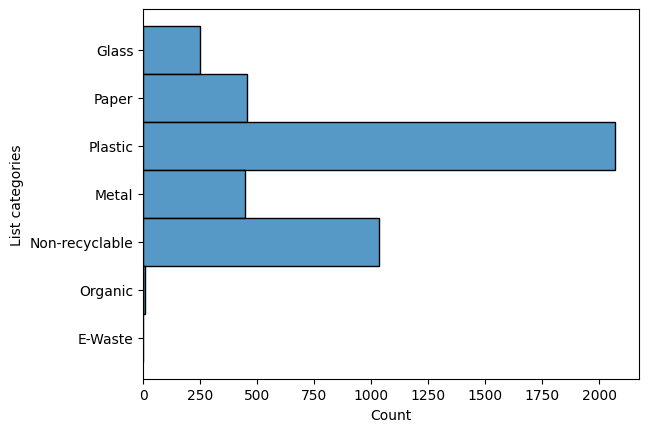

In [21]:
sns.histplot(data=hist_categories, y='List categories')

In [22]:
hist_categories['List categories'].value_counts()

Plastic           2071
Non-recyclable    1035
Paper              455
Metal              448
Glass              248
Organic              8
E-Waste              2
Name: List categories, dtype: int64

We have a clear class inbalance with the following classes having very few annotations:
- Organic (only 8)
- E-Waste (only 2)

And the following classes with few annotations (< 1000):
- Glass
- Metal
- Paper


### Drinking Waste Classification

### Drinking Waste Classification